Based on paper:

Özer, İlyas, Serhat Berat Efe, and Harun Özbay. "CNN/Bi‐LSTM‐based deep learning algorithm for classification of power quality disturbances by using spectrogram images." International Transactions on Electrical Energy Systems 31.12 (2021): e13204.

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

from keras.layers import GaussianNoise

from parameters_CINC11CINC17_balanced import parameters

# Set the seed value for experiment reproducibility.
seed = 2
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
!python --version 

print('Tensorflow version', tf.__version__)

Python 3.8.11Tensorflow version 2.9.1



In [3]:
parameters = parameters()
data_length = parameters['data_length']

### Import dataset

In [4]:
dataset_path = parameters['path_training_data']
model_save_path = parameters['path_model']
data_dir = pathlib.Path(dataset_path)

The dataset WAV files are stored in two folders: `0` and `1`

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['0' '1']


Extract the ECGs into a list called `filenames`, and shuffle it:

In [6]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total samples:', num_samples)
print('Number of samples per label:', len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
# print('Example file tensor:', filenames[0])

Number of total samples: 4048
Number of samples per label: 2024


Split `filenames` into training, validation and test sets using a 80:10:10 ratio, respectively:
# cross validation


In [7]:
nr_train = int(num_samples * 0.8)
nr_test_val = int(num_samples / 10)

train_files = filenames[:nr_train]
val_files = filenames[nr_train: nr_train + nr_test_val]
test_files = filenames[-nr_test_val:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 3238
Validation set size 404
Test set size 404


## Read the ecg files and their labels

In this section you will preprocess the dataset, creating decoded tensors for the waveforms and the corresponding labels. Note that:

- Each WAV file contains time-series data with a set number of samples per second.
- Each sample represents the <a href="https://en.wikipedia.org/wiki/Amplitude" class="external">amplitude</a> of the ECG signal at that specific time.
- In a <a href="https://en.wikipedia.org/wiki/Audio_bit_depth" class="external">16-bit</a> system, like WAV files, the amplitude values range from -32,768 to 32,767.
- The <a href="https://en.wikipedia.org/wiki/Sampling_(signal_processing)#Audio_sampling" class="external">sample rate</a> for the ECG data used is 500 Hz

The shape of the tensor returned by `tf.audio.decode_wav` is `[samples, channels]`, which is `[5000, 1]` for 500 Hz 10 second data. 

In [9]:
test_file = tf.io.read_file(dataset_path+'/1/1009856_0.wav')
test_ecg, _ = tf.audio.decode_wav(contents=test_file)
test_ecg.shape

TensorShape([5000, 1])

Now, let's define a function that preprocesses the dataset's raw WAV ECG files into audio tensors:

In [10]:
def decode_wav_file(ecg_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
    ecg, _ = tf.audio.decode_wav(contents=ecg_binary)
    return tf.squeeze(ecg, axis=-1)


Define a function that creates labels using the parent directories for each file:

- Split the file paths into `tf.RaggedTensor`s (tensors with ragged dimensions—with slices that may have different lengths).

In [11]:
def get_label(file_path):
    parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
    # Note: You'll use indexing here instead of tuple unpacking to enable this
    # to work in a TensorFlow graph.
    return parts[-2]

Define another helper function—`get_waveform_and_label`—that puts it all together:

- The input is the WAV ECG filename.
- The output is a tuple containing the ECG and label tensors ready for supervised learning.

In [12]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    ecg_binary = tf.io.read_file(file_path)
    waveform = decode_wav_file(ecg_binary)
    return waveform, label

Build the training set to extract the ECG-label pairs:

- Create a `tf.data.Dataset` with `Dataset.from_tensor_slices` and `Dataset.map`, using `get_waveform_and_label` defined earlier.

You'll build the validation and test sets using a similar procedure later on.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

Let's plot a few ECG waveforms:

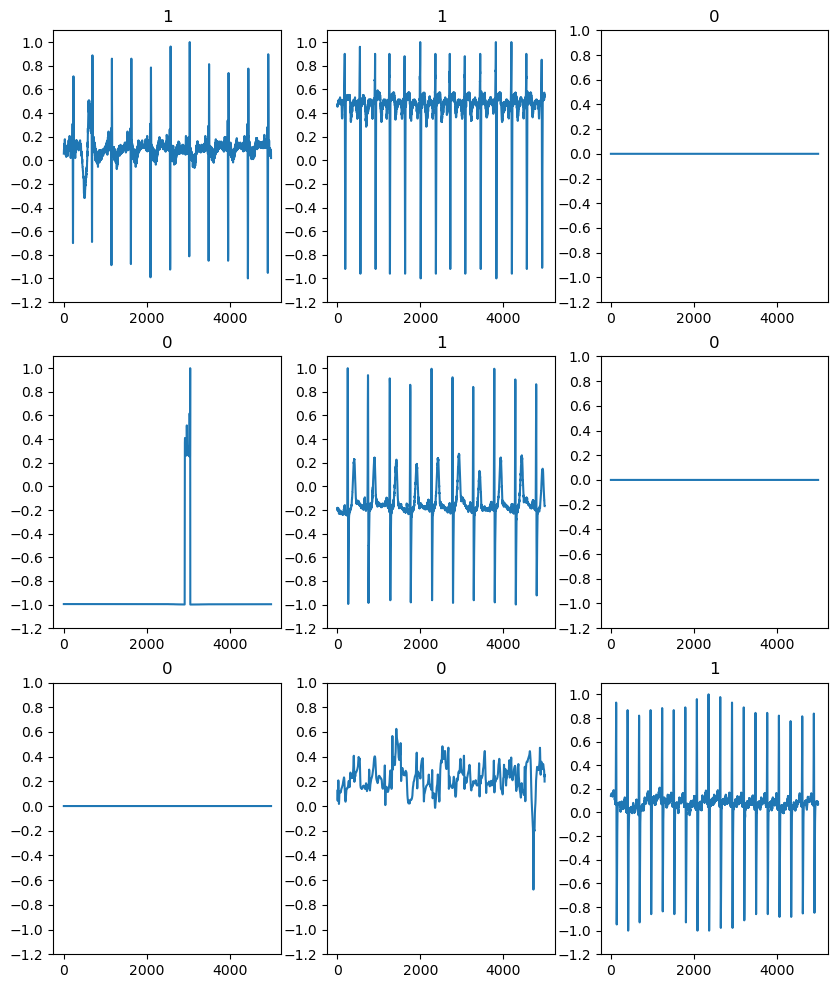

In [14]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (ecg, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(ecg.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the <a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform" class="external">short-time Fourier transform (STFT)</a> to convert the waveforms to as <a href="https://en.wikipedia.org/wiki/Spectrogram" clas="external">spectrograms</a>, which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. 
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [15]:
def get_spectrogram(waveform):
    # cropping for waveform smaller than the desired 5000 (not the case for this data)
#     waveform = waveform[:5000]

    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    
    # In case the data is different length (not the case for this data)
#     zero_padding = tf.zeros(
#       [input_len] - tf.shape(waveform),
#       dtype=tf.float32)
#     equal_length = tf.concat([waveform, zero_padding], 0) 

    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram

In [16]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy()
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)

Label: b'1'
Waveform shape: (5000,)
Spectrogram shape: (38, 129, 1)


Defining a function for displaying a spectrogram:

In [17]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
        # Convert the frequencies to log scale and transpose, so that the time is
        # represented on the x-axis (columns).
        # Add an epsilon to avoid taking a log of zero.
        log_spec = np.log(spectrogram.T + np.finfo(float).eps)
        height = log_spec.shape[0]
        width = log_spec.shape[1]
        X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
        Y = range(height)
        ax.pcolormesh(X, Y, log_spec, shading='auto')

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

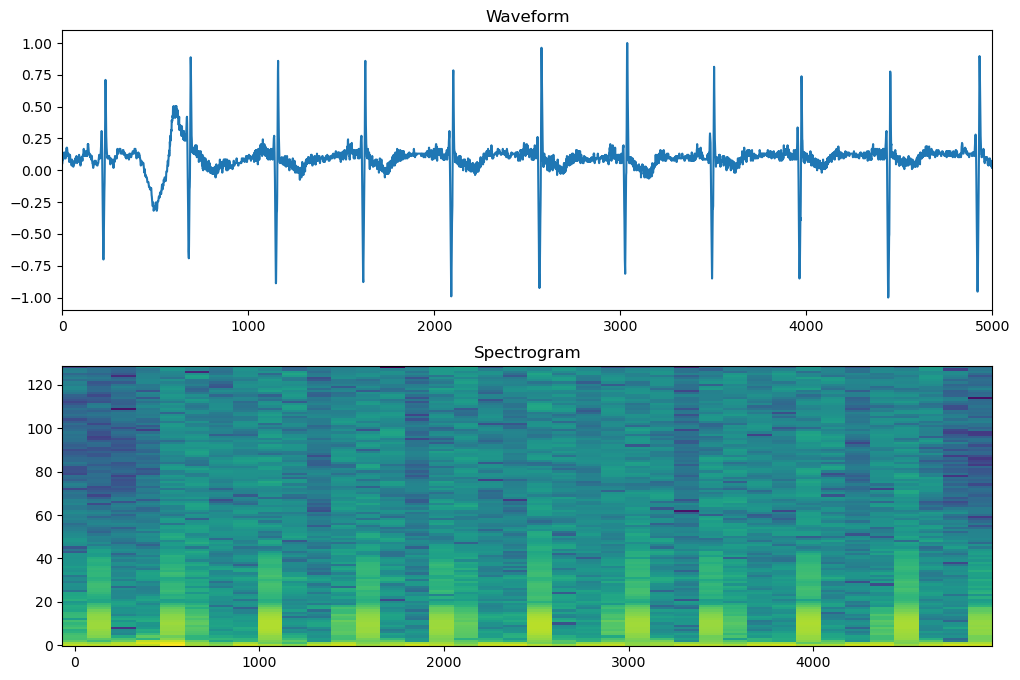

In [18]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, data_length])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now, define a function that transforms the waveform dataset into spectrograms and their corresponding labels as integer IDs:

In [19]:
def get_spectrogram_and_label_id(ecg, label):
    spectrogram = get_spectrogram(ecg)
    label_id = tf.math.argmax(label == commands)
    return spectrogram, label_id

Map `get_spectrogram_and_label_id` across the dataset's elements with `Dataset.map`:

In [20]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

Examine the spectrograms for different examples of the dataset:

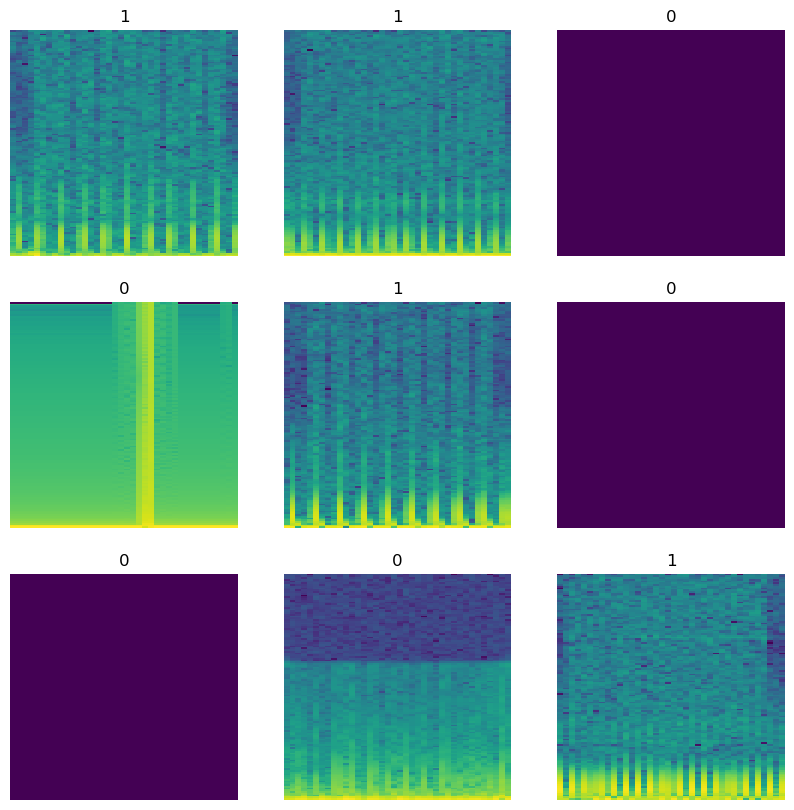

In [21]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.show()

## Build and train the model

Repeat the training set preprocessing on the validation and test sets:

In [22]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
    return output_ds

In [23]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training:

In [24]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [25]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

`tf.keras.Sequential` model uses the following Keras preprocessing layers:

- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).


# CNN/Bi-LSTM model

The CNN part of the algorithm consists of three blocks that downsample the data through convolutions. Each block consists of a CNN layer, a max pooling layer, and a dropout layer. 

In [26]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))


model = models.Sequential([
    layers.Input(shape=(input_shape[0],input_shape[1])),
    norm_layer,
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(),
    layers.Dropout(0.2),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(),
    layers.Dropout(0.2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(),
    layers.Dropout(0.2),
    layers.Dense(100), 
    layers.LSTM(100),
    layers.Dropout(0.2),
    layers.Dense(29),
    layers.Dense(num_labels, activation='sigmoid'),
])

model.summary()


Input shape: (38, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 38, 129)          3         
 n)                                                              
                                                                 
 conv1d (Conv1D)             (None, 36, 32)            12416     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 18, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 300 epochs:

In [28]:
EPOCHS = 300
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
#     callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=30),
)


Epoch 1/300


C:\Users\kirin\anaconda3\envs\tensorFlowKeras\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


51/51 [==============================] - 6s 61ms/step - loss: 0.6288 - accuracy: 0.7097 - val_loss: 0.5537 - val_accuracy: 0.7748
Epoch 2/300
51/51 [==============================] - 1s 19ms/step - loss: 0.4607 - accuracy: 0.8085 - val_loss: 0.3464 - val_accuracy: 0.8292
Epoch 3/300
51/51 [==============================] - 1s 18ms/step - loss: 0.2643 - accuracy: 0.8996 - val_loss: 0.2345 - val_accuracy: 0.9084
Epoch 4/300
51/51 [==============================] - 1s 18ms/step - loss: 0.1901 - accuracy: 0.9250 - val_loss: 0.1923 - val_accuracy: 0.9307
Epoch 5/300
51/51 [==============================] - 1s 18ms/step - loss: 0.1705 - accuracy: 0.9348 - val_loss: 0.1687 - val_accuracy: 0.9356
Epoch 6/300
51/51 [==============================] - 1s 18ms/step - loss: 0.1566 - accuracy: 0.9385 - val_loss: 0.1478 - val_accuracy: 0.9480
Epoch 7/300
51/51 [==============================] - 1s 19ms/step - loss: 0.1399 - accuracy: 0.9453 - val_loss: 0.1373 - val_accuracy: 0.9480
Epoch 8/300
51/51 

51/51 [==============================] - 1s 18ms/step - loss: 0.0238 - accuracy: 0.9926 - val_loss: 0.0779 - val_accuracy: 0.9802
Epoch 116/300
51/51 [==============================] - 1s 20ms/step - loss: 0.0255 - accuracy: 0.9910 - val_loss: 0.0970 - val_accuracy: 0.9752
Epoch 117/300
51/51 [==============================] - 1s 19ms/step - loss: 0.0253 - accuracy: 0.9917 - val_loss: 0.0793 - val_accuracy: 0.9802
Epoch 118/300
51/51 [==============================] - 1s 18ms/step - loss: 0.0239 - accuracy: 0.9935 - val_loss: 0.0864 - val_accuracy: 0.9777
Epoch 119/300
51/51 [==============================] - 1s 19ms/step - loss: 0.0264 - accuracy: 0.9895 - val_loss: 0.0805 - val_accuracy: 0.9802
Epoch 120/300
51/51 [==============================] - 1s 19ms/step - loss: 0.0237 - accuracy: 0.9910 - val_loss: 0.0840 - val_accuracy: 0.9802
Epoch 121/300
51/51 [==============================] - 1s 18ms/step - loss: 0.0252 - accuracy: 0.9904 - val_loss: 0.0829 - val_accuracy: 0.9777
Epoch 

Epoch 172/300
51/51 [==============================] - 1s 19ms/step - loss: 0.0187 - accuracy: 0.9941 - val_loss: 0.1118 - val_accuracy: 0.9752
Epoch 173/300
51/51 [==============================] - 1s 20ms/step - loss: 0.0208 - accuracy: 0.9929 - val_loss: 0.0973 - val_accuracy: 0.9777
Epoch 174/300
51/51 [==============================] - 1s 19ms/step - loss: 0.0140 - accuracy: 0.9938 - val_loss: 0.0915 - val_accuracy: 0.9802
Epoch 175/300
51/51 [==============================] - 1s 21ms/step - loss: 0.0130 - accuracy: 0.9957 - val_loss: 0.0942 - val_accuracy: 0.9777
Epoch 176/300
51/51 [==============================] - 1s 22ms/step - loss: 0.0140 - accuracy: 0.9954 - val_loss: 0.1144 - val_accuracy: 0.9777
Epoch 177/300
51/51 [==============================] - 1s 21ms/step - loss: 0.0148 - accuracy: 0.9944 - val_loss: 0.0935 - val_accuracy: 0.9802
Epoch 178/300
51/51 [==============================] - 1s 21ms/step - loss: 0.0128 - accuracy: 0.9963 - val_loss: 0.1109 - val_accuracy:

Epoch 229/300
51/51 [==============================] - 1s 20ms/step - loss: 0.0111 - accuracy: 0.9963 - val_loss: 0.1239 - val_accuracy: 0.9802
Epoch 230/300
51/51 [==============================] - 1s 21ms/step - loss: 0.0105 - accuracy: 0.9972 - val_loss: 0.1111 - val_accuracy: 0.9802
Epoch 231/300
51/51 [==============================] - 1s 22ms/step - loss: 0.0097 - accuracy: 0.9975 - val_loss: 0.1287 - val_accuracy: 0.9777
Epoch 232/300
51/51 [==============================] - 1s 21ms/step - loss: 0.0106 - accuracy: 0.9966 - val_loss: 0.1341 - val_accuracy: 0.9777
Epoch 233/300
51/51 [==============================] - 1s 20ms/step - loss: 0.0091 - accuracy: 0.9966 - val_loss: 0.1151 - val_accuracy: 0.9802
Epoch 234/300
51/51 [==============================] - 1s 20ms/step - loss: 0.0078 - accuracy: 0.9972 - val_loss: 0.1205 - val_accuracy: 0.9827
Epoch 235/300
51/51 [==============================] - 1s 20ms/step - loss: 0.0138 - accuracy: 0.9944 - val_loss: 0.1039 - val_accuracy:

Epoch 286/300
51/51 [==============================] - 1s 18ms/step - loss: 0.0048 - accuracy: 0.9994 - val_loss: 0.1448 - val_accuracy: 0.9777
Epoch 287/300
51/51 [==============================] - 1s 19ms/step - loss: 0.0087 - accuracy: 0.9969 - val_loss: 0.1203 - val_accuracy: 0.9802
Epoch 288/300
51/51 [==============================] - 1s 18ms/step - loss: 0.0080 - accuracy: 0.9969 - val_loss: 0.0974 - val_accuracy: 0.9777
Epoch 289/300
51/51 [==============================] - 1s 18ms/step - loss: 0.0086 - accuracy: 0.9975 - val_loss: 0.1147 - val_accuracy: 0.9851
Epoch 290/300
51/51 [==============================] - 1s 19ms/step - loss: 0.0063 - accuracy: 0.9981 - val_loss: 0.1193 - val_accuracy: 0.9827
Epoch 291/300
51/51 [==============================] - 1s 20ms/step - loss: 0.0052 - accuracy: 0.9981 - val_loss: 0.1193 - val_accuracy: 0.9827
Epoch 292/300
51/51 [==============================] - 1s 20ms/step - loss: 0.0052 - accuracy: 0.9975 - val_loss: 0.1482 - val_accuracy:

Let's plot the training and validation loss curves to check how the model has improved during training:

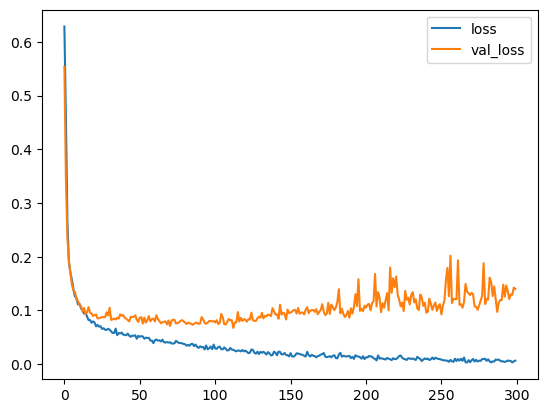

In [29]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Save the model for later usage:

In [30]:
model.save(model_save_path+'/'+parameters['model_name'])

INFO:tensorflow:Assets written to: C:\Users\kirin\Documents\Untitled Folder\Code Python toolbox\ECGAssess-main\Code\model/CNN_LSTM_model_cinc11cinc17\assets


INFO:tensorflow:Assets written to: C:\Users\kirin\Documents\Untitled Folder\Code Python toolbox\ECGAssess-main\Code\model/CNN_LSTM_model_cinc11cinc17\assets


Load previously trained model:

In [31]:
# model = tf.keras.models.load_model(model_save_path+'/'+parameters['model_name'])

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [32]:
test_ecg = []
test_labels = []

for ecg, label in test_ds:
    test_ecg.append(ecg.numpy())
    test_labels.append(label.numpy())

test_ecg = np.array(test_ecg)
test_labels = np.array(test_labels)

In [33]:
y_pred = np.argmax(model.predict(test_ecg), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc}')

13/13 [==============================] - 1s 5ms/step
Test set accuracy: 0.9702970297029703


<!-- ![image.png](attachment:image.png) -->


Sensitivity=[a/(a+c)]×100

Specificity=[d/(b+d)]×100

In [34]:
true_positive_linus = 0
for i in range(len(y_true)):
    true_positive_linus += (y_true[i] * y_pred[i])
    
false_negative_linus = sum(y_true) - true_positive_linus

sensitivity_linus = (true_positive_linus / (true_positive_linus + false_negative_linus)) * 100

print('Sensitivity', sensitivity_linus)

false_positive_linus = sum(y_pred) - true_positive_linus
true_negative_linus = len(y_pred) - true_positive_linus - false_positive_linus - false_negative_linus

specificity_linus = (true_negative_linus / (false_positive_linus + true_negative_linus)) * 100

print('Specificity', specificity_linus)

Sensitivity 98.52216748768473
Specificity 95.52238805970148


F1 score

<!-- ![image.png](attachment:image.png) -->

In [35]:
f1_score_linus = ((true_positive_linus)/(true_positive_linus + 0.5 * (false_positive_linus + false_negative_linus)))

print('F1 score', f1_score_linus)

F1 score 0.970873786407767


### Display a confusion matrix

Use a <a href="https://developers.google.com/machine-learning/glossary#confusion-matrix" class="external">confusion matrix</a> to check how well the model did classifying each of the commands in the test set:


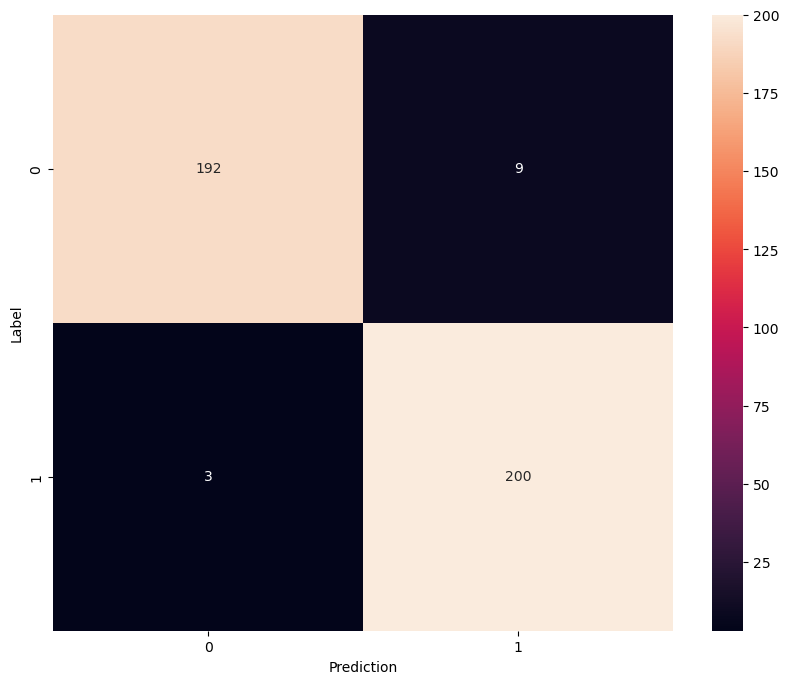

In [36]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# External validation BUTQDB

Import data and make sure that the labels are balanced, the 0-label group is the smallest. So, load that first and then load the 1-label group with the same size. 

In [37]:
test_dir = parameters['path_BUTQDB_test']
test_dir = pathlib.Path(test_dir)
test_filenames0 = tf.io.gfile.glob(str(test_dir) + '/0/*')
test_filenames0 = tf.random.shuffle(test_filenames0)
test_filenames1 = tf.io.gfile.glob(str(test_dir) + '/1/*')
test_filenames1 = tf.random.shuffle(test_filenames1)
test_filenames1 = test_filenames1[:len(test_filenames0)] 
test_filenames = tf.concat([test_filenames0, test_filenames1], 0)
test_num_samples = len(test_filenames)
print('Number of total samples:', test_num_samples)
print('Number of samples per label:', len(tf.io.gfile.listdir(str(test_dir/commands[0]))))
# print('Example file tensor:', test_filenames[0])

Number of total samples: 10570
Number of samples per label: 5285


Preprocess the data:

In [38]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
    return output_ds

Display the spectrograms of the created dataset:

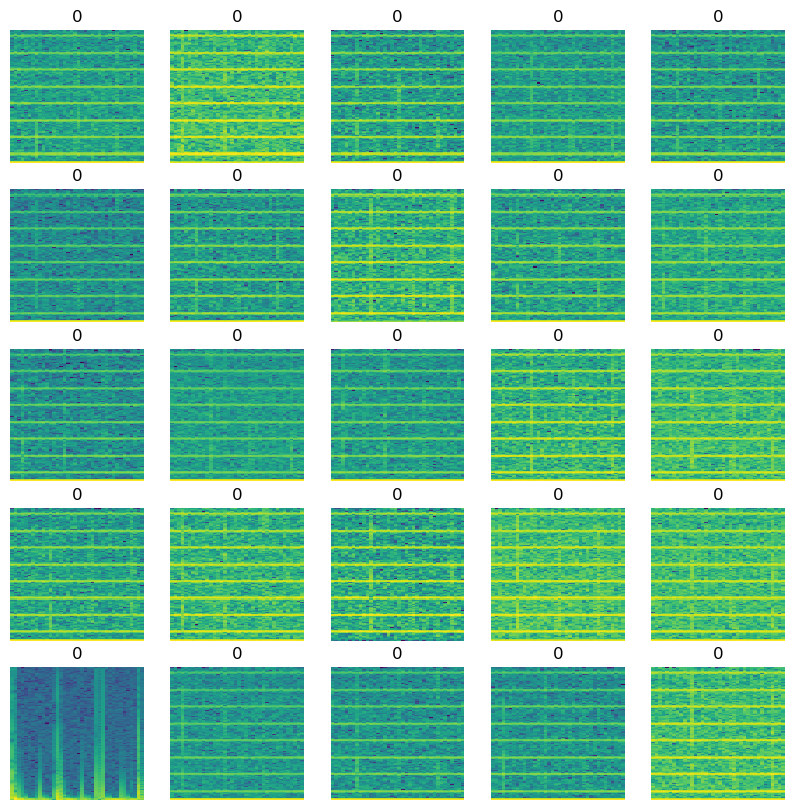

In [39]:
test_but_qdb = preprocess_dataset(test_filenames)

rows = 5
cols = 5
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(test_but_qdb.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.show()
# batch_size_ptb = 2
# test_ptb_ds = test_ptb_ds.batch(batch_size_ptb)
test_but_qdb = test_but_qdb.cache().prefetch(AUTOTUNE)

In [40]:
def preprocess_dataset_plot(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
    return output_ds

In [41]:
# val_but_qdb_plot = preprocess_dataset_plot(val_filenames)
    
# # val = val_but_qdb_plot.take(10)
# # for i in range(10):
# n = 2

# for waveform_but_qdb, label_but_qdb in val_but_qdb_plot.take(n):    
#     label_but_qdb = label_but_qdb.numpy()
#     spectrogram_but_qdb = get_spectrogram(waveform_but_qdb)

#     print('Label:', label_but_qdb)
#     print('Waveform shape:', waveform_but_qdb.shape)
#     print('Spectrogram shape:', spectrogram_but_qdb.shape)

#     fig, axes = plt.subplots(2, figsize=(12, 8))
#     timescale = np.arange(waveform_but_qdb.shape[0])
#     axes[0].plot(timescale, waveform_but_qdb.numpy())
#     axes[0].set_title('Waveform')
#     axes[0].set_xlim([0, data_length])

#     plot_spectrogram(spectrogram_but_qdb.numpy(), axes[1])
#     axes[1].set_title('Spectrogram')
#     plt.show()

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [42]:
test_but_qdb_ecg = []
test_but_qdb_labels = []

for ecg, label in test_but_qdb:
    test_but_qdb_ecg.append(ecg.numpy())
    test_but_qdb_labels.append(label.numpy())

test_but_qdb_ecg = np.array(test_but_qdb_ecg)
test_but_qdb_labels = np.array(test_but_qdb_labels)

In [43]:
y_pred_but_qdb = np.argmax(model.predict(test_but_qdb_ecg), axis=1)
y_true_but_qdb = test_but_qdb_labels

test_acc_but_qdb = sum(y_pred_but_qdb == y_true_but_qdb) / len(y_true_but_qdb)
print(f'Test set accuracy: {test_acc_but_qdb}')

331/331 [==============================] - 18s 53ms/step
Test set accuracy: 0.9601702932828761


In [44]:
true_positive_but_qdb = 0
for i in range(len(y_true_but_qdb)):
    true_positive_but_qdb += (y_true_but_qdb[i] * y_pred_but_qdb[i])
    
false_negative_but_qdb = sum(y_true_but_qdb) - true_positive_but_qdb

sensitivity_but_qdb = (true_positive_but_qdb / (true_positive_but_qdb + false_negative_but_qdb)) * 100

print('Sensitivity', sensitivity_but_qdb)

false_positive_but_qdb = sum(y_pred_but_qdb) - true_positive_but_qdb
true_negative_but_qdb = len(y_pred_but_qdb) - true_positive_but_qdb - false_positive_but_qdb - false_negative_but_qdb

specificity_but_qdb = (true_negative_but_qdb / (false_positive_but_qdb + true_negative_but_qdb)) * 100

print('Specificity', specificity_but_qdb)

Sensitivity 92.4314096499527
Specificity 99.60264900662251


In [45]:
f1_score_but_qdb = ((true_positive_but_qdb)/(true_positive_but_qdb + 0.5 * (false_positive_but_qdb + false_negative_but_qdb)))

print('F1 score', f1_score_but_qdb)

F1 score 0.9586890393484447


### Display a confusion matrix

Use a <a href="https://developers.google.com/machine-learning/glossary#confusion-matrix" class="external">confusion matrix</a> to check how well the model did classifying each of the commands in the test set:


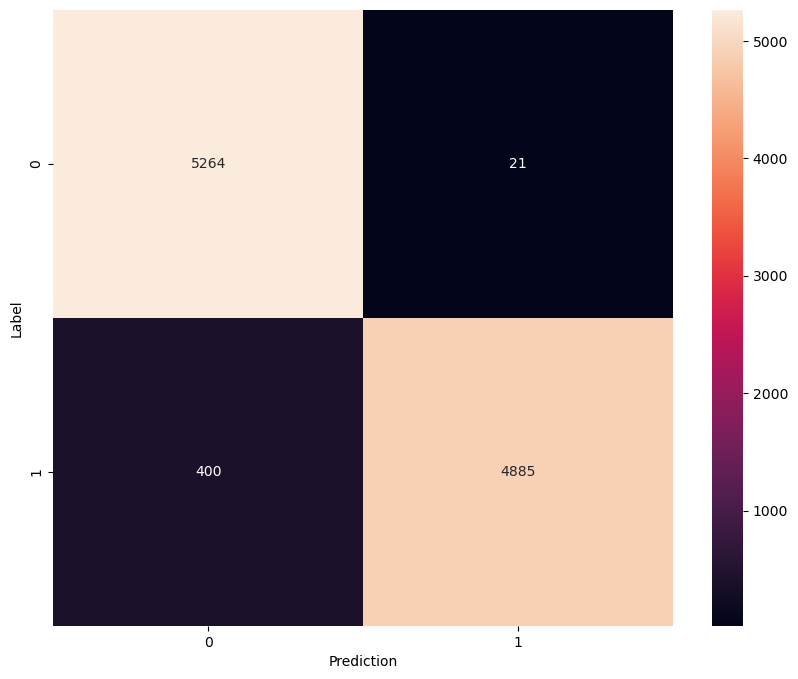

In [46]:
confusion_mtx = tf.math.confusion_matrix(y_true_but_qdb, y_pred_but_qdb)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()